## Doppler Ultrasound

We are first going to simulate the pulses that are leaving our transducer. Diagnostic ultrasound frequencies are from 1-20 MHz, however, for our specific use case of
aortic


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Initialize the Transducer Characteristics and Common Time Array
freq_t = 1E6 # 1 MHz transducer
wavelength = 1/freq_t # this is intrinsic to our system
pulsewidth = 5 * wavelength # this is intrinsic to our system
PRF = 10E3 # aka pulse repetition frequency, 10 kHz the high end
btwnpulse = 1/PRF # this will be what we change depending on the speed of the RBCs

t = np.arange(0,(pulsewidth+btwnpulse)*4,1E-8); # 1/(1E-8) will be our sampling frequency, I believe

Text(0.5, 1.0, 'Waveforms being sent out by Tranducer')

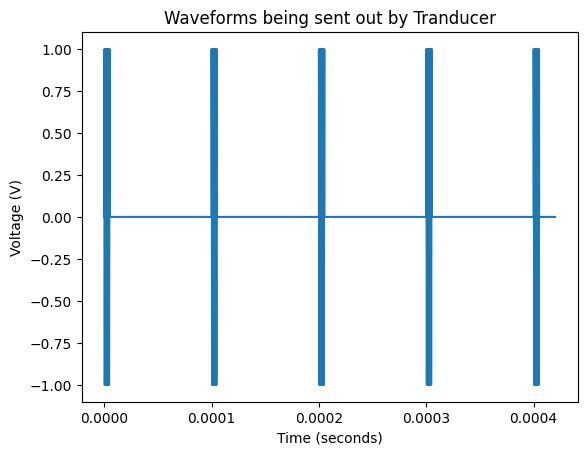

In [4]:
rect = t*0
rects = t*0

for n in np.arange(0,5,1): # making the pulse waves and their frequencies
   newrect = (t<pulsewidth+btwnpulse*n)*1*(t>btwnpulse*(n))*np.cos(2*np.pi*1E6*(t-n*btwnpulse))
   rects = rects + newrect

transduceroutput = rects # this is what we are sending out 
plt.plot(t,transduceroutput)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being sent out by Tranducer')

Text(0.5, 1.0, 'Waveforms being received by Tranducer: Severe Aortic Stenosis')

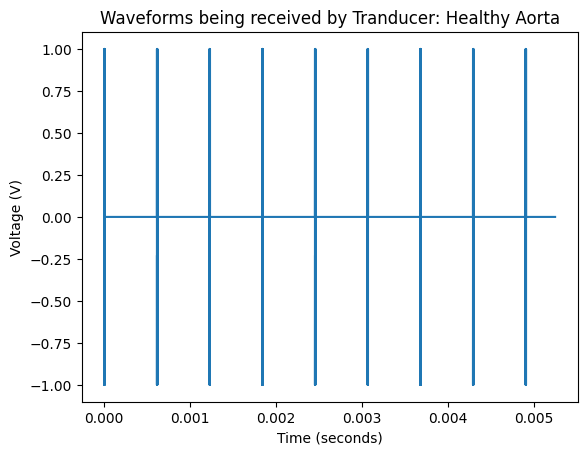

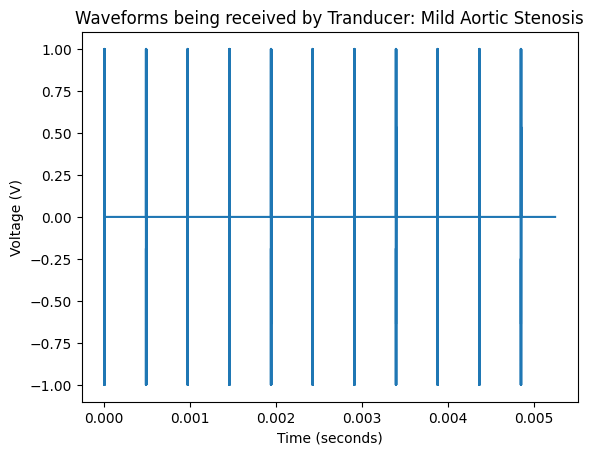

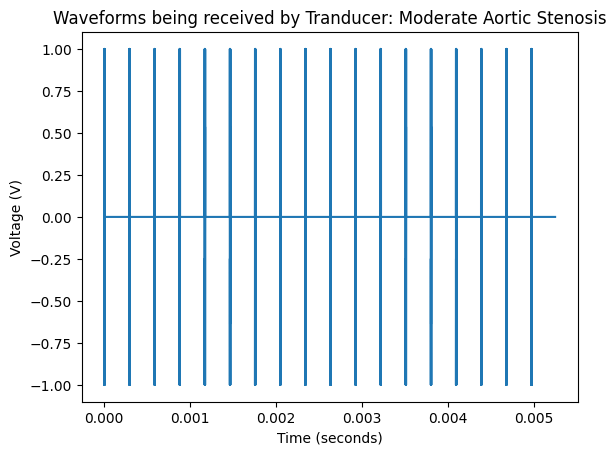

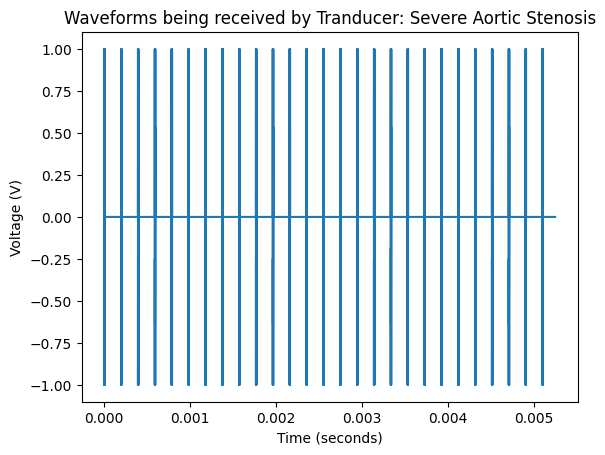

In [7]:
t = np.arange(0,(pulsewidth+btwnpulse)*50,1E-8)

def makepulses(t,velocity,theta,reps,pulsewidth,btwnpulse): # t is an array, velocity in m/s
    rects = t*0
    Fd = 2*1E6*(velocity/1540)*np.cos(theta)
    btwnpulse = btwnpulse + 1/Fd
    for n in np.arange(0,reps,1): # making the pulse waves and their frequencies
        newrect = (t<pulsewidth+btwnpulse*n)*1*(t>btwnpulse*(n))*np.cos(2*np.pi*1E6*(t-n*btwnpulse))
        rects = rects + newrect

    return rects


healthy = makepulses(t,1.5,0,10,pulsewidth,btwnpulse)
mild = makepulses(t,2,0,12,pulsewidth,btwnpulse)
mod = makepulses(t,4,0,20,pulsewidth,btwnpulse)
severe = makepulses(t,8,0,50,pulsewidth,btwnpulse)

# print(btwnpulse)

plt.figure()
plt.plot(t,healthy)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being received by Tranducer: Healthy Aorta')

plt.figure()
plt.plot(t,mild)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being received by Tranducer: Mild Aortic Stenosis')

plt.figure()
plt.plot(t,mod)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being received by Tranducer: Moderate Aortic Stenosis')

plt.figure()
plt.plot(t,severe)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being received by Tranducer: Severe Aortic Stenosis')


Formula for doppler: velocity = c(Fr - Ft)/(2 * F0 * cos(theta))

Simplified Bernoulli Equation: P = 4v^2 to convert velocity to pressure to diagnose stenosis

Text(0.5, 1.0, 'Fourier Transform')

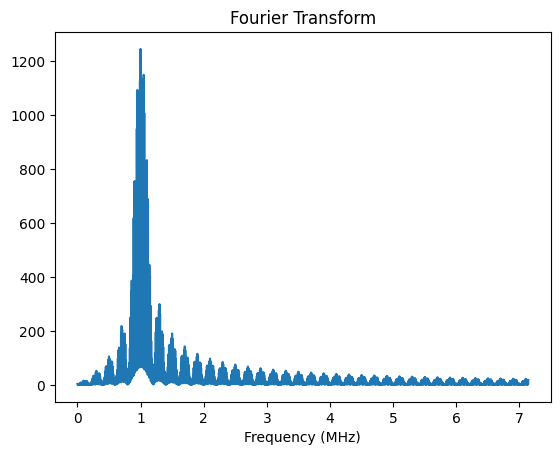

In [5]:
time = t[1] - t[0]
freq = np.fft.fftshift(np.fft.fftfreq(len(transduceroutput), time))
freq_transducer = np.abs(np.fft.fftshift(np.fft.fft(transduceroutput)))
length = len(freq) //2
plt.plot(freq[length:length+3000]/1e6, freq_transducer[length:length+3000])
plt.xlabel("Frequency (MHz)")
plt.title("Fourier Transform")
# plt.plot(freq, fref)

## Healthy Reconstruction

Average time between peaks: 0.00061370875
Time shift:  0.0005137087499999999
Frequency:  1629.4374163640327
Velocity in m/s  1.2546668106003052


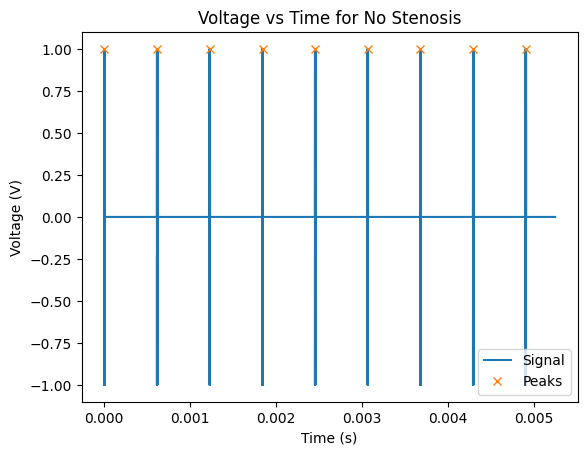

In [122]:
peaks, _ = find_peaks(healthy, distance=1000)
# Calculate the time differences between consecutive peaks
peak_times = t[peaks]  # Times of the peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_healthy = np.mean(time_diffs)
time_shift_healthy = average_time_between_peaks_healthy - 0.0001
total_freq_shift = 1/average_time_between_peaks_healthy
print("Average time between peaks:", average_time_between_peaks_healthy)
print("Time shift: ", time_shift_healthy)
print("Frequency: ", total_freq_shift)
# print("Delta f: ", delta_f)

c=1540
velocity_healthy = c*total_freq_shift/(2*1e6)
print("Velocity in m/s ", velocity_healthy)

# Plot the signal and the peaks
plt.plot(t, healthy, label='Signal')
plt.plot(t[peaks], healthy[peaks], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for No Stenosis')
plt.legend()
plt.show()

Pressure Calculation

In [123]:
pressure_healthy = 4*velocity_healthy**2
print("Pressure is: ", pressure_healthy, 'mmHg')

area_healthy = 2* c * average_time_between_peaks_healthy
print("Area of Aortic Valve: ", area_healthy, 'cm^2')

Pressure is:  6.296755222487768 mmHg
Area of Aortic Valve:  1.8902229499999998 cm^2


## Mild Reconstruction

Average time between peaks: 0.0004852
Time shift:  0.0003852
Frequency:  2061.0057708161585
Velocity in m/s  1.5869744435284419


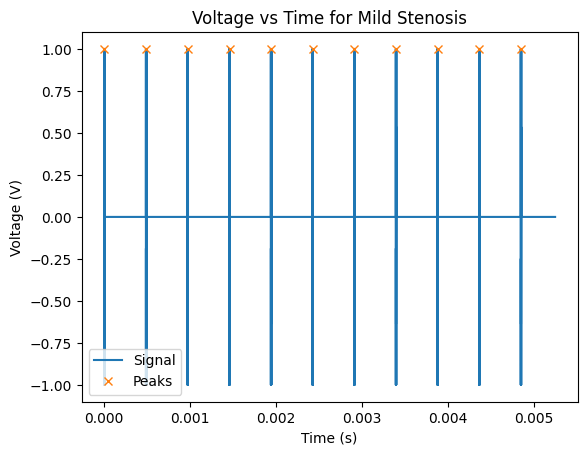

In [120]:
peaks, _ = find_peaks(mild, distance=1000)
# Calculate the time differences between consecutive peaks
peak_times = t[peaks]  # Times of the peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_mild = np.mean(time_diffs)
time_shift_mild = average_time_between_peaks_mild - 0.0001
total_freq_shift = 1/average_time_between_peaks_mild
print("Average time between peaks:", average_time_between_peaks_mild)
print("Time shift: ", time_shift_mild)
print("Frequency: ", total_freq_shift)
# print("Delta f: ", delta_f)

c=1540
velocity_mild = c*total_freq_shift/(2*1e6)
print("Velocity in m/s ", velocity_mild)

# Plot the signal and the peaks
plt.plot(t, mild, label='Signal')
plt.plot(t[peaks], mild[peaks], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Mild Stenosis')
plt.legend()
plt.show()

Pressure Calculation

In [119]:
pressure_mild = 4*velocity_mild**2
print("Pressure is: ", pressure_mild, 'mmHg')

area_mild = 2 * c * average_time_between_peaks_mild
print("Area of Aortic Valve: ", area_mild, 'cm^2')

Pressure is:  10.07395153764963 mmHg
Area of Aortic Valve:  1.494416 cm^2


## Moderate Reconstruction

Average time between peaks: 0.0002926176470588235
Time shift:  0.00019261764705882353
Frequency:  3417.4288873253595
Velocity in m/s  2.6314202432405267


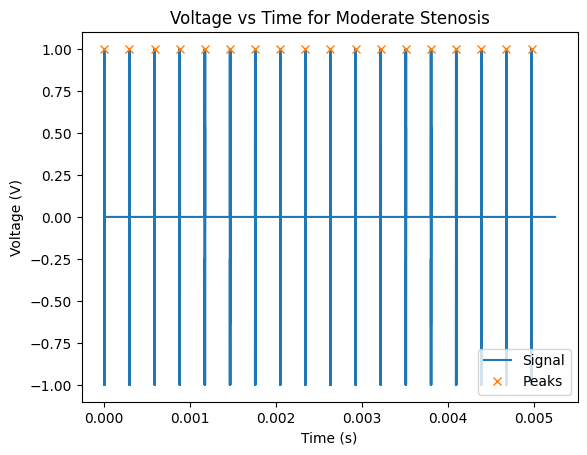

In [125]:
peaks, _ = find_peaks(mod, distance=1000)
# Calculate the time differences between consecutive peaks
peak_times = t[peaks]  # Times of the peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_mod = np.mean(time_diffs)
time_shift = average_time_between_peaks_mod - 0.0001
total_freq_shift = 1/average_time_between_peaks_mod
print("Average time between peaks:", average_time_between_peaks_mod)
print("Time shift: ", time_shift)
print("Frequency: ", total_freq_shift)
# print("Delta f: ", delta_f)

c=1540
velocity_mod = c*total_freq_shift/(2*1e6)
print("Velocity in m/s ", velocity_mod)

# Plot the signal and the peaks
plt.plot(t, mod, label='Signal')
plt.plot(t[peaks], mod[peaks], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Moderate Stenosis')
plt.legend()
plt.show()

Pressure Calculation

In [128]:
pressure_mod = 4*velocity_mod**2
print("Pressure is: ", pressure_mod, 'mmHg')

area_mod = 2 * c * average_time_between_peaks_mod
print("Area of Aortic Valve: ", area_mod, 'cm^2')

Pressure is:  27.69748998614413 mmHg
Area of Aortic Valve:  0.9012623529411764 cm^2


## Severe Reconstruction

Average time between peaks: 0.00019625
Time shift:  9.625e-05
Frequency:  5095.541401273886
Velocity in m/s  3.9235668789808917


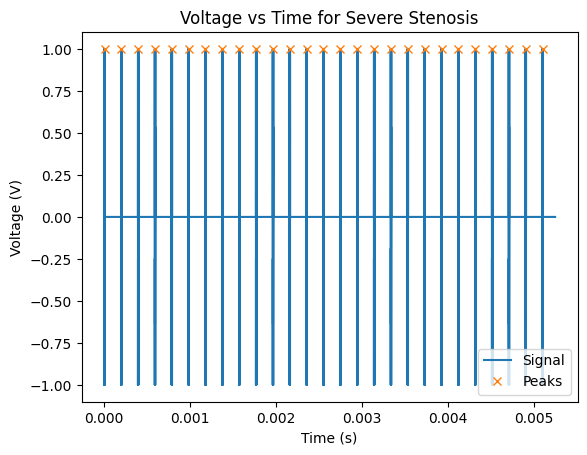

In [130]:
peaks, _ = find_peaks(severe, distance=1000)
# Calculate the time differences between consecutive peaks
peak_times = t[peaks]  # Times of the peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_severe = np.mean(time_diffs)
time_shift = average_time_between_peaks_severe - 0.0001
total_freq_shift = 1/average_time_between_peaks_severe
print("Average time between peaks:", average_time_between_peaks_severe)
print("Time shift: ", time_shift)
print("Frequency: ", total_freq_shift)
# print("Delta f: ", delta_f)

c=1540
velocity_severe = c*total_freq_shift/(2*1e6)
print("Velocity in m/s ", velocity_severe)

# Plot the signal and the peaks
plt.plot(t, severe, label='Signal')
plt.plot(t[peaks], severe[peaks], 'x', label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Severe Stenosis')
plt.legend()
plt.show()

Pressure Calculation

In [131]:
pressure_severe = 4*velocity_severe**2
print("Pressure is: ", pressure_severe, 'mmHg')

area_severe = 2 * c * average_time_between_peaks_severe
print("Area of Aortic Valve: ", area_severe, 'cm^2')

Pressure is:  61.57750821534342 mmHg
Area of Aortic Valve:  0.60445 cm^2


## Parameter Sweep of Angles

Average time between peaks: 0.00061370875
Time shift:  0.0005137087499999999
Frequency:  1629.4374163640327


Text(0, 0.5, 'Velocity (m/s)')

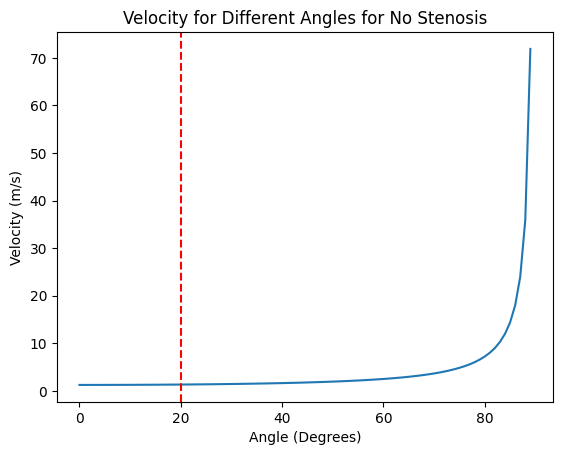

In [109]:
peaks, _ = find_peaks(healthy, distance=1000)
# Calculate the time differences between consecutive peaks
peak_times = t[peaks]  # Times of the peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks = np.mean(time_diffs)
time_shift = average_time_between_peaks - 0.0001
total_freq_shift = 1/average_time_between_peaks
print("Average time between peaks:", average_time_between_peaks)
print("Time shift: ", time_shift)
print("Frequency: ", total_freq_shift)

angles = np.arange(0, 90)
angles_radians = np.radians(angles)

c=1540
velocity_healthy_angle = c*total_freq_shift/(2*1e6*np.cos(angles_radians))
plt.plot(angles, velocity_healthy_angle)
plt.axvline(x=20, color='r', linestyle='--', label='20 degrees')
plt.title('Velocity for Different Angles for No Stenosis')
plt.xlabel("Angle (Degrees)")
plt.ylabel('Velocity (m/s)')

## Analyzing Direction of Flow

In [1]:
# Looking at Reverse Flow, want to demonstrate that you have to move the transducer once you know the anatomy. Can't just leave it there.
# Right now, we have the transducer moving toward the transducer.
dv = 0.1
velocity_array = np.arange(-8,0,dv) # in m/s
velocity_array2 = np.arange(0,8,dv)
#print((velocity_array))
theta = 0 # the blood flow is going directly towards
Fd_array = 2*1E6*(velocity_array/1540)*np.cos(theta)
Fd_array2 = 2*1E6*(velocity_array2/1540)*np.cos(theta)
plt.figure()
plt.plot(velocity_array,Fd_array)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Frequency Shift (Hz)')
plt.title('Frequency Shifts over Speed')
plt.grid()


# Notice how the frequency shifts are negative. This presents us a problem...
# Earlier we calculated the time between pulses, or the period
btwnpulse_array = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array
btwnpulse_array2 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array2
plt.figure(figsize=(14,6))
plt.suptitle('Incidence Theta = 0')
plt.subplot(1,2,1)
plt.plot(velocity_array,btwnpulse_array)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

plt.subplot(1,2,2)
plt.plot(velocity_array2,btwnpulse_array2)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')


# When we look at the graphs, we cannot have a negative period. Periods must be positive. Thus, it is up to the ultrasound technician to wiggle the ultrasound transducer to
# an angle whereby they can properly interpret the results. A solid understanding of anatomy and physiology is required.

theta2 = np.pi # the blood flow is going directly away
Fd_array3 = 2*1E6*(velocity_array/1540)*np.cos(theta2)
Fd_array4 = 2*1E6*(velocity_array2/1540)*np.cos(theta2)
btwnpulse_array3 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array3
btwnpulse_array4 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array4
plt.figure(figsize=(14,6))
plt.suptitle('Incidence Theta = 180')
plt.subplot(1,2,1)
plt.plot(velocity_array,btwnpulse_array3)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

plt.subplot(1,2,2)
plt.plot(velocity_array2,btwnpulse_array4)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

# 180 degrees is when blood is going away, however, it is only valid for negative values of velocity. Again ,it is up to the technician to adjust the transducer
# to an angle which can read. Then based on the physiology, they can find out the direction of the blood, at least for pulse wave doppler. Maybe we need to explore continuous doppler.

NameError: name 'np' is not defined

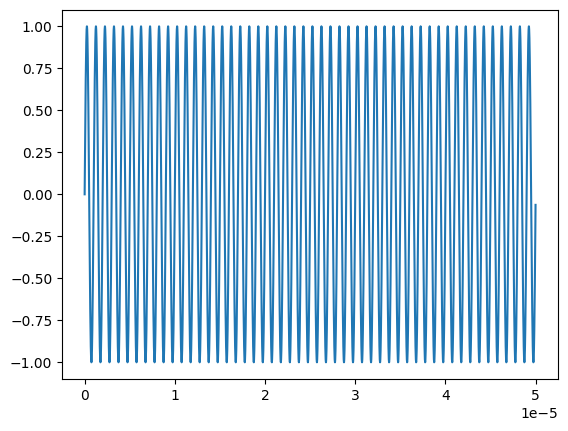

In [9]:
# Continuous Doppler Simulation (simplified) - WORK IN PROGRESS IF WE WANT

# Initialize the Transducer Characteristics and Common Time Array
freq_t = 1E6 # 1 MHz transducer
wavelength = 1/freq_t # this is intrinsic to our system
pulsewidth = 5 * wavelength # this is intrinsic to our system
PRF = 10E3 # aka pulse repetition frequency, 10 kHz the high end
btwnpulse = 1/PRF # this will be what we change depending on the speed of the RBCs

t_cont = np.arange(0,(pulsewidth*10),1E-8)

cont_out = np.sin(2*np.pi*freq_t*t_cont)
plt.plot(t_cont,cont_out)

